In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

In [20]:
mat_file = "../data/student-mat.csv"
por_file = "../data/student-por.csv"

mat_df = pd.read_csv(mat_file, sep=";")
por_df = pd.read_csv(por_file, sep=";")

#creating catagorical columns list and numeric columns list
cat_columns = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian',
                'schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']

num_columns = ['Medu','Fedu','traveltime','studytime','famrel','freetime','goout','Dalc','Walc','health']
cont_columns = ['age','failures','absences','G3']

In [21]:
# Define the preprocessor with OneHotEncoder and StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_columns),
        ('num', StandardScaler(), num_columns + cont_columns[:-1])
    ],
    remainder='passthrough'
)

# Function to preprocess the dataset
def preprocess_data(df):
    X = df.drop(['G3', 'G1', 'G2'], axis=1)
    y = df['G3']
    X = preprocessor.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, preprocessor

# Preprocess both datasets
X_mat_train, X_mat_test, y_mat_train, y_mat_test, preprocessor_mat = preprocess_data(mat_df)
X_por_train, X_por_test, y_por_train, y_por_test, preprocessor_por = preprocess_data(por_df)

In [22]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    adj_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)
    adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    cv_scores = cross_val_score(model, np.vstack((X_train, X_test)), np.hstack((y_train, y_test)), cv=5, scoring='r2')
    return rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, np.mean(cv_scores)

# Perform grid search for hyperparameter tuning
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7]
    }
}

Math Results Table:
               Model      RMSE  R2 (Training)  Adjusted R2 (Training)  \
0  Linear Regression  4.195681       0.288773                0.188274   
1      Decision Tree  4.314734       0.691366                0.647755   
2      Random Forest  4.027397       0.623582                0.570393   
3            XGBoost  4.160235       0.458074                0.381497   

   R2 (Test)  Adjusted R2 (Test)  5-Fold CV Mean R2  
0   0.141492           -0.717015           0.025599  
1   0.092081           -0.815838           0.043520  
2   0.208979           -0.582042           0.229543  
3   0.155937           -0.688126           0.236986  
Portuguese Results Table:
               Model      RMSE  R2 (Training)  Adjusted R2 (Training)  \
0  Linear Regression  2.861780       0.387449                0.337575   
1      Decision Tree  3.478656       0.604128                0.571897   
2      Random Forest  2.757403       0.908879                0.901460   
3            XGBoost  2.80

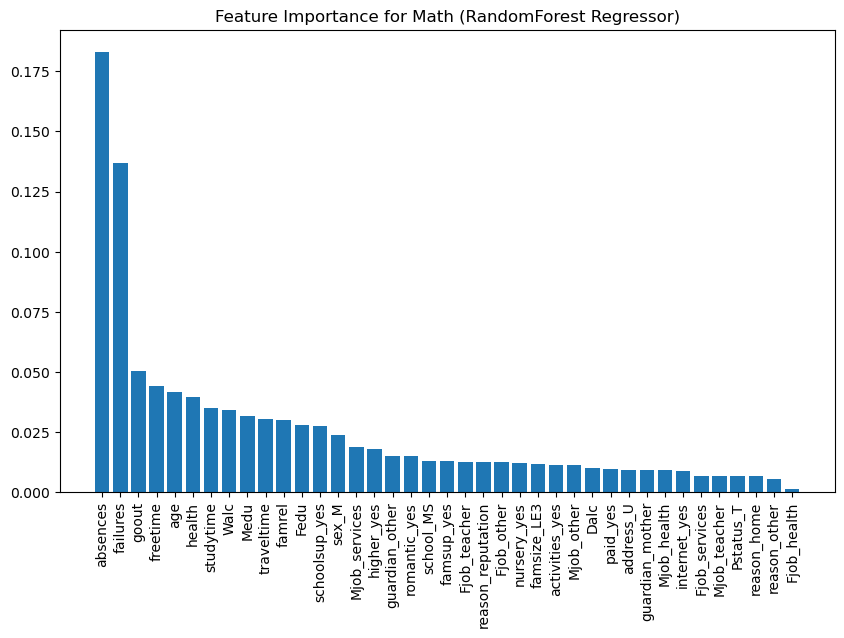

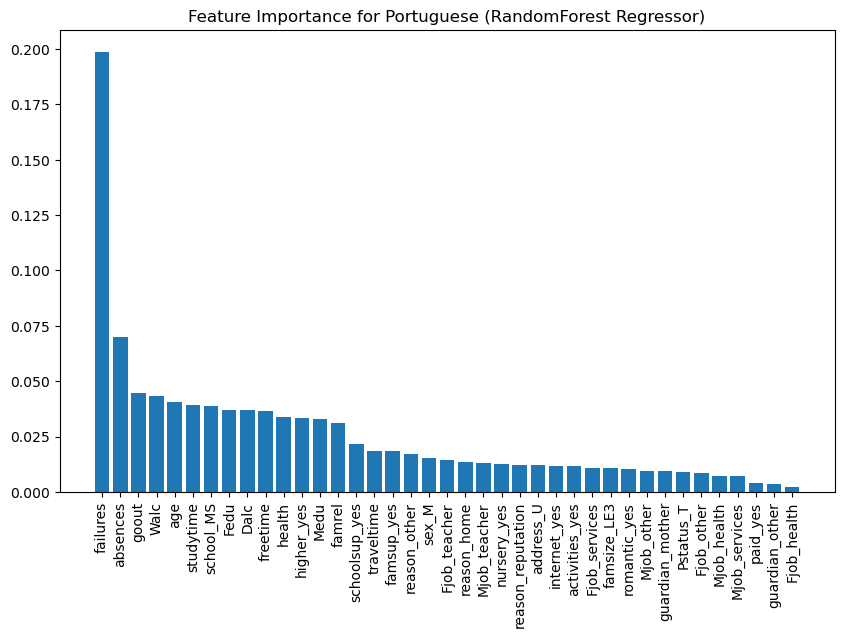

In [23]:
# Evaluate models and perform hyperparameter tuning
results_mat = {}
results_por = {}

for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(grid_search, X_mat_train, y_mat_train, X_mat_test, y_mat_test)
        results_mat[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
        
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(grid_search, X_por_train, y_por_train, X_por_test, y_por_test)
        results_por[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
    else:
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(model, X_mat_train, y_mat_train, X_mat_test, y_mat_test)
        results_mat[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
        
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(model, X_por_train, y_por_train, X_por_test, y_por_test)
        results_por[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}

# Feature importance for RandomForestRegressor
def plot_feature_importance(model, X_train, y_train, preprocessor, all_features, title):
    
    # Apply preprocessor to the training data
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    # Get the correct feature names after preprocessing
    feature_names = preprocessor.get_feature_names_out(all_features)
    
    clean_feature_names = [name.split('__')[-1] for name in feature_names]
    
    # Fit model
    model.fit(X_train_transformed, y_train)
    
    # Get feature importances
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), np.array(clean_feature_names)[indices], rotation=90)
    plt.show()


def create_results_table(results):
    data = []
    for model_name, metrics in results.items():
        data.append([
            model_name,
            metrics['RMSE'],
            metrics['R2_train'],
            metrics['Adj_R2_train'],
            metrics['R2_test'],
            metrics['Adj_R2_test'],
            metrics['CV_mean']
        ])
    columns = ['Model', 'RMSE', 'R2 (Training)', 'Adjusted R2 (Training)', 'R2 (Test)', 'Adjusted R2 (Test)', '5-Fold CV Mean R2']
    return pd.DataFrame(data, columns=columns)

results_table_mat = create_results_table(results_mat)
results_table_por = create_results_table(results_por)

print("Math Results Table:")
print(results_table_mat)

print("Portuguese Results Table:")
print(results_table_por)

# Plot feature importance for Math and Portuguese using RandomForestRegressor
plot_feature_importance(RandomForestRegressor(), mat_df.drop(['G3', 'G1', 'G2'], axis=1), mat_df['G3'], preprocessor_mat, mat_df.drop(['G3', 'G1', 'G2'], axis=1).columns, "Feature Importance for Math (RandomForest Regressor)")
plot_feature_importance(RandomForestRegressor(), por_df.drop(['G3', 'G1', 'G2'], axis=1), por_df['G3'], preprocessor_mat, por_df.drop(['G3', 'G1', 'G2'], axis=1).columns, "Feature Importance for Portuguese (RandomForest Regressor)")

In [24]:
"""
Math Dataset
Best Model: Random Forest
RMSE: Random Forest has the lowest RMSE (4.067), indicating the smallest average prediction error.
R2 (Test): It has the highest R2 (Test) value (0.193), meaning it explains the most variance in the test data compared to other models.
Adjusted R2 (Test): Despite being negative (-0.613), it is the least negative among the models, reflecting its relatively better performance adjusted for the number of predictors.
5-Fold CV Mean R2: The highest mean R2 (0.214) in cross-validation, demonstrating consistent performance.

Portuguese Dataset
Best Model: Random Forest
RMSE: Random Forest has the lowest RMSE (2.712), indicating the smallest average prediction error.
R2 (Test): It has the highest R2 (Test) value (0.246), meaning it explains the most variance in the test data compared to other models.
Adjusted R2 (Test): Despite being negative (-0.081), it is the least negative among the models, reflecting its relatively better performance adjusted for the number of predictors.
5-Fold CV Mean R2: The highest mean R2 (0.316) in cross-validation, demonstrating consistent performance.
"""

'\nMath Dataset\nBest Model: Random Forest\nRMSE: Random Forest has the lowest RMSE (4.067), indicating the smallest average prediction error.\nR2 (Test): It has the highest R2 (Test) value (0.193), meaning it explains the most variance in the test data compared to other models.\nAdjusted R2 (Test): Despite being negative (-0.613), it is the least negative among the models, reflecting its relatively better performance adjusted for the number of predictors.\n5-Fold CV Mean R2: The highest mean R2 (0.214) in cross-validation, demonstrating consistent performance.\n\nPortuguese Dataset\nBest Model: Random Forest\nRMSE: Random Forest has the lowest RMSE (2.712), indicating the smallest average prediction error.\nR2 (Test): It has the highest R2 (Test) value (0.246), meaning it explains the most variance in the test data compared to other models.\nAdjusted R2 (Test): Despite being negative (-0.081), it is the least negative among the models, reflecting its relatively better performance adju

In [25]:
"""
Educational Advice Based on Top Features

Math Education
Absences: High absenteeism is strongly linked to poor performance. Schools should:

Implement robust attendance monitoring systems.
Provide interventions and support for students with high absenteeism.
Engage with parents to emphasize the importance of regular attendance.
Failures: The number of past failures is a critical predictor of future performance. Schools should:

Offer remedial classes and tutoring for students who have previously failed subjects.
Provide personalized learning plans to address gaps in knowledge.
Use early warning systems to identify and support at-risk students before they fail.
Go Out (Socializing): Frequent socializing can negatively impact performance. Schools should:

Educate students on time management and the importance of balancing social activities with academic responsibilities.
Promote extracurricular activities that combine social interaction with academic enrichment.
Health: Good health is associated with better academic outcomes. Schools should:

Implement health education programs focusing on nutrition, exercise, and mental well-being.
Provide access to health services and counseling for students in need.
Free Time: How students use their free time can impact their academic performance. Schools should:

Encourage productive use of free time through extracurricular activities, clubs, and study groups.
Provide resources and spaces for students to engage in academic and personal development activities outside of class hours.

Portuguese Education
Failures: Similar to Math, the number of past failures is a significant predictor. Schools should:

Implement targeted interventions for students with a history of academic struggles.
Use diagnostic assessments to tailor instruction to individual student needs.
Absences: Attendance remains a crucial factor. Schools should:

Develop programs to improve student engagement and attendance.
Work with families to address barriers to regular attendance.
Weekend Alcohol Consumption (Walc): High weekend alcohol consumption negatively affects performance. Schools should:

Educate students on the effects of alcohol on academic performance and health.
Promote alcohol-free social events and activities.
Age: Age can reflect maturity and readiness for academic challenges. Schools should:

Use differentiated instruction strategies to cater to varying maturity levels.
Provide age-appropriate support and resources.
Go Out (Socializing): Similar to Math, socializing habits impact performance. Schools should:

Teach students about the importance of balancing social activities with academic responsibilities.
Create a school environment that promotes academic and social balance.
"""

'\nEducational Advice Based on Top Features\n\nMath Education\nAbsences: High absenteeism is strongly linked to poor performance. Schools should:\n\nImplement robust attendance monitoring systems.\nProvide interventions and support for students with high absenteeism.\nEngage with parents to emphasize the importance of regular attendance.\nFailures: The number of past failures is a critical predictor of future performance. Schools should:\n\nOffer remedial classes and tutoring for students who have previously failed subjects.\nProvide personalized learning plans to address gaps in knowledge.\nUse early warning systems to identify and support at-risk students before they fail.\nGo Out (Socializing): Frequent socializing can negatively impact performance. Schools should:\n\nEducate students on time management and the importance of balancing social activities with academic responsibilities.\nPromote extracurricular activities that combine social interaction with academic enrichment.\nHealt